In [4]:
import json
from pathlib import Path

import astropy.uncertainty as unc
import astropy.units as u
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from astropy.modeling.models import Linear1D
from astropy.modeling.fitting import LMLSQFitter
from astropy.time import Time

from feadme.parser import Template, Parameter, Line, Shape, Disk, Mask

finfo = np.finfo(float)

In [5]:
disk_profile = Disk(
        name="halpha_disk",
        center=Parameter(name="center", distribution="normal", low=6562.819 - 5, high=6562.819 + 5, loc=6562.819, scale=1),
        inner_radius=Parameter(name="inner_radius", distribution="log_uniform", low=1e2, high=5e3, loc=1e3, scale=1e2),
        delta_radius=Parameter(name="delta_radius", distribution="log_uniform", low=5e2, high=1e4, loc=5e3, scale=5e2),
        inclination=Parameter(name="inclination", distribution="normal", low=0, high=np.pi / 2, loc=np.pi / 4, scale=np.pi / 8),
        sigma=Parameter(name="sigma", distribution="log_uniform", low=2e2, high=1e4, loc=1e3, scale=1e2),
        q=Parameter(name="q", distribution="uniform", low=0.5, high=4, loc=2, scale=1),
        eccentricity=Parameter(name="eccentricity", distribution="uniform", low=0, high=1, loc=0.5, scale=0.25),
        apocenter=Parameter(name="apocenter", distribution="uniform", low=0, high=2 * np.pi, loc=np.pi, scale=np.pi / 4),
        scale=Parameter(name="scale", distribution="uniform", low=0, high=1, loc=0.5, scale=0.1),
        offset=Parameter(name="offset", distribution="uniform", low=0, high=0.05, fixed=True, value=0)
    )

halpha_narrow_line = Line(
    name="halpha_narrow",
    shape=Shape.gaussian,
    center=Parameter(name="center", distribution="normal", low=6548, high=6568, loc=6562.819, scale=2, shared="halpha_disk"),
    amplitude=Parameter(name="amplitude", distribution="uniform", low=0, high=1, loc=0.5, scale=1),
    vel_width=Parameter(name="vel_width", distribution="log_uniform", low=1e1, high=1e3, loc=1e2, scale=1e1),
)

halpha_broad_line = Line(
    name="halpha_broad",
    shape=Shape.gaussian,
    center=Parameter(name="center", distribution="normal", low=6548, high=6568, loc=6562.819, scale=2, shared="halpha_disk"),
    amplitude=Parameter(name="amplitude", distribution="uniform", low=0, high=1, loc=0.5, scale=1),
    vel_width=Parameter(name="vel_width", distribution="log_uniform", low=1e3, high=1e4, loc=1e2, scale=1e1),
)

niir_narrow_line = Line(
    name="niir_narrow",
    shape=Shape.gaussian,
    center=Parameter(name="center", distribution="normal", low=6583.46 - 5, high=6583.46 + 5, loc=6583.46, scale=2),
    amplitude=Parameter(name="amplitude", distribution="uniform", low=0, high=1, loc=0.5, scale=1),
    vel_width=Parameter(name="vel_width", distribution="log_uniform", low=1e1, high=1e3, loc=1e2, scale=1e1, shared="halpha_narrow"),
)

niil_narrow_line = Line(
    name="niil_narrow",
    shape=Shape.gaussian,
    center=Parameter(name="center", distribution="normal", low=6548.05 - 5, high=6548.05 + 5, loc=6548.05, scale=2),
    amplitude=Parameter(name="amplitude", distribution="uniform", low=0, high=1, loc=0.5, scale=1),
    vel_width=Parameter(name="vel_width", distribution="log_uniform", low=1e1, high=1e3, loc=1e2, scale=1e1, shared="halpha_narrow"),
)

siir_narrow_line = Line(
    name="siir_narrow",
    shape=Shape.gaussian,
    center=Parameter(name="center", distribution="normal", low=6730.81 - 5, high=6730.81 + 5, loc=6730.81, scale=2),
    amplitude=Parameter(name="amplitude", distribution="uniform", low=0, high=1, loc=0.5, scale=1),
    vel_width=Parameter(name="vel_width", distribution="log_uniform", low=1e1, high=1e3, loc=1e2, scale=1e1, shared="halpha_narrow"),
)

siil_narrow_line = Line(
    name="siil_narrow",
    shape=Shape.gaussian,
    center=Parameter(name="center", distribution="normal", low=6716.44 - 5, high=6716.44 + 5, loc=6716.44, scale=2),
    amplitude=Parameter(name="amplitude", distribution="uniform", low=0, high=1, loc=0.5, scale=1),
    vel_width=Parameter(name="vel_width", distribution="log_uniform", low=1e1, high=1e3, loc=1e2, scale=1e1, shared="halpha_narrow"),
)

white_noise=Parameter(name="white_noise", distribution="uniform", low=-10, high=1)

In [6]:
ingest_dir = Path("/Users/nmearl/Downloads/ZTF-DPEs-main/SDSSspectroscopy")

# obj_tab = Table.read("/Users/nmearl/Downloads/ZTF-DPEs-main/object_info.cds", format='ascii.cds')
# obj_tab['name'] = [x.strip() for x in obj_tab['ZTF']]
rs_tab = Table.read("/Users/nmearl/research/tde_agn_comparison/templates/redshifts.csv", format='ascii.ecsv')

output_dir = Path("/Users/nmearl/research/tde_agn_comparison")

for file_path in ingest_dir.glob("*.txt"):
    label = file_path.stem.split('_')[0]

    if label not in rs_tab['name']:
        continue

    tab = Table.read(file_path, format='ascii.basic', names=['wave', 'flux', 'flux_err'])
    redshift = rs_tab[rs_tab['name'] == label]['redshift'].value.data[0]

    if not redshift:
        print(f"{label} has missing redshift")
        continue

    # ==============
    # Parse and transform data
    # ==============
    rest_wave = tab['wave'] / (1 + redshift)

    if label != "ZTF18aaymybb":
        flux = tab['flux'] * 1e-17 * u.erg / u.s / u.cm ** 2 / u.AA
        flux_err = tab['flux_err'] * 1e-17 * u.erg / u.s / u.cm ** 2 / u.AA
        wave = tab['wave'] * u.AA
    else:
        flux = tab['flux'] * u.erg / u.s / u.cm ** 2 / u.AA
        flux_err = tab['flux_err'] * u.erg / u.s / u.cm ** 2 / u.AA
        wave = tab['wave'] * u.AA

    # wave = wave[ha_mask]
    # flux = flux[ha_mask]
    # flux_err = flux_err[ha_mask]

    # uflux = unc.normal(flux, std=flux_err, n_samples=100000).to(u.mJy, u.spectral_density(wave))
    # flux, flux_err = uflux.pdf_median(), uflux.pdf_std()
    # snr = flux / flux_err

    flux = flux.to(u.mJy, u.spectral_density(wave))
    flux_err = flux_err.to(u.mJy, u.spectral_density(wave))
    snr_mask = flux_err.value < 1

    # flux_err[snr < 3] = np.abs(flux[snr < 3]) * 0.1
    wave = wave[snr_mask]
    flux = flux[snr_mask]
    flux_err = flux_err[snr_mask]

    if len(flux) == 0:
        print(f"{label} has no data")
        continue

    Table({'wave': wave, 'flux': flux, 'flux_err': flux_err}).write(output_dir / "data" / f"{label}.csv", format='ascii.csv', overwrite=True)

    # ==============
    # Update template
    # ==============
    template = Template(
        name=label,
        redshift=redshift,
        data_path=str(output_dir / "data" / f"{label}.csv"),
        # data_path=f"/datasets/transient-data/{label}.csv",
        # data_path=f"/home/kasm-user/research/data/{label}.csv",
        disk_profiles=[
            disk_profile,
        ],
        line_profiles=[
            halpha_narrow_line,
            # halpha_broad_line,
            niir_narrow_line,
            niil_narrow_line,
            siir_narrow_line,
            siil_narrow_line,
        ],
        white_noise=white_noise,
        mask=[Mask(lower_limit=6350, upper_limit=6800)]
    )

    template.name = label
    template.redshift = redshift

    for prof in template.disk_profiles:
        prof.scale.high = flux.max().value * 1.1

    for prof in template.line_profiles:
        prof.amplitude.high = flux.max().value * 1.1

    with open(output_dir / "templates" / f"{label}.json", "w") as f:
        json.dump(template.model_dump(), f, indent=4)

In [7]:
# for temp in Path("/Users/nmearl/Desktop/pod-files/templates").glob("*.json"):
#     with open(temp, "r") as f:
#         loaded_data = json.load(f)
#         template = Template(**loaded_data)
#
#     print(temp.stem, template.data_path)
#     data_path = Path(template.data_path)
#     print(data_path.name, data_path.stem)
#     new_data_path = Path("/Users/nmearl/research/tde_agn_comparison/data") / data_path.name
#
#     # Overwrite the data path in the template
#     template.data_path = str(new_data_path)
#     # Save the updated template
#     with open(temp, "w") as f:
#         json.dump(template.model_dump(), f, indent=4)

0.07141392331938316
6818.428030031537


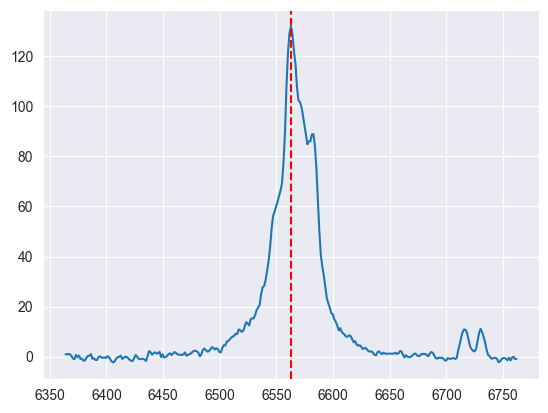

In [8]:
tab = Table.read("/Users/nmearl/Downloads/ZTF-DPEs-main/SDSSspectroscopy/ZTF18aaavwka_subtracted.txt", format='ascii.basic', names=['wave', 'flux', 'flux_err'])

sflux = tab['flux'].value.copy()
sflux[:len(tab['wave']) //2] = 0
max_ind = np.argmax(sflux)
ha_wave = tab['wave'][max_ind]

z = (ha_wave - 6562.819) / 6562.819
print(z)

rest_wave = tab['wave'] / (1 + z)
mask = (rest_wave > 6363) & (rest_wave < 6763)

print(np.min(tab['wave'][mask]), )

fig, ax = plt.subplots()

# ax.plot(tab['wave'], tab['flux'], label='Original')
ax.plot(rest_wave[mask], tab['flux'][mask])
ax.axvline(6562.819, color='r', linestyle='--', label='Halpha')

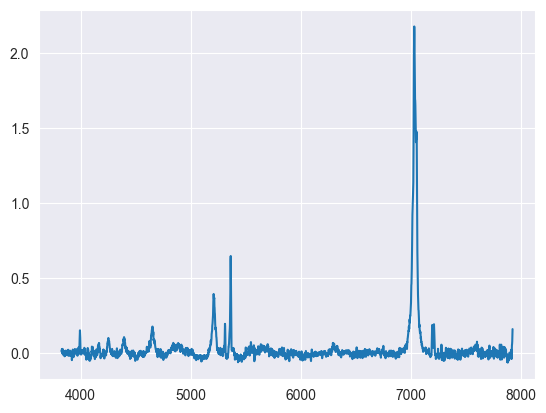

In [9]:
aahhuol_tab = Table.read("/Users/nmearl/Desktop/pod-files/data/ZTF18aaavwka.csv", format='ascii.csv')

fig, ax = plt.subplots()

ax.plot(aahhuol_tab['wave'], aahhuol_tab['flux'], label='Aahhuol')

In [10]:
# rs_dict = {}
#
# for temp_path in  Path("/Users/nmearl/research/tde_agn_comparison/templates").glob("*.json"):
#     with open(temp_path, "r") as f:
#         loaded_data = json.load(f)
#         template = Template(**loaded_data)
#
#     rs_dict.setdefault("name", []).append(template.name)
#     rs_dict.setdefault("redshift", []).append(template.redshift)
#
# Table(rs_dict).write("/Users/nmearl/research/tde_agn_comparison/templates/redshifts.csv", format='ascii.ecsv', overwrite=True)

In [11]:
# best_fit_model